# Trading Strategy

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
# read data
df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})

df_sentiscores3 = pd.read_csv("../2_data/topic_3_LDA_sentiment_stats.csv", parse_dates=["date"])
df_sentiscores5 = pd.read_csv("../2_data/topic_5_LDA_sentiment_stats.csv", parse_dates=["date"])

# transform date columns to datetime
start_date = "2019-01-01"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# Add predix：VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# Add predix：NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# Sentiment data is also filtered for date ranges
df_sentiscores3 = df_sentiscores3[df_sentiscores3["date"].between(start_date, end_date)]
df_sentiscores5 = df_sentiscores5[df_sentiscores5["date"].between(start_date, end_date)]


# merge dataframes


df_merged3 = df_all.merge(df_sentiscores3[["date", "sentiment_std", "avg_sentiment_score"]], on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

df_merged5 = df_all.merge(df_sentiscores5[["date", "sentiment_std", "avg_sentiment_score"]], on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")


# check for missing values
print("Missing values per column:")

print(df_merged3.isnull().sum())
print(df_merged5.isnull().sum())
# check for duplicates

print(df_merged3.tail())
print(df_merged5.tail())
# save the merged dataframes to CSV files

df_merged3.to_csv("../2_data/LDA3factor_data_0522.csv", index=False)
df_merged5.to_csv("../2_data/LDA5factor_data_0522.csv", index=False)

Missing values per column:
date                     0
sentiment_std          137
avg_sentiment_score     65
vix_open               359
vix_high               359
vix_low                359
vix_close              359
nvda_open              359
nvda_high              359
nvda_low               359
nvda_close             359
nvda_volume            359
dtype: int64
date                     0
sentiment_std          157
avg_sentiment_score     76
vix_open               359
vix_high               359
vix_low                359
vix_close              359
nvda_open              359
nvda_high              359
nvda_low               359
nvda_close             359
nvda_volume            359
dtype: int64
           date  sentiment_std  avg_sentiment_score   vix_open   vix_high  \
1150 2022-02-24       0.590097            -0.031250  37.500000  37.790001   
1151 2022-02-25       0.625144             0.172414  31.680000  32.000000   
1152 2022-02-26       0.517549             0.375000        NaN      

In [14]:
# read data
df = pd.read_csv('../2_data/LDA5factor_data_0522.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)
# Screen out non-trading days first (e.g., days with no stock prices)
df = df.dropna(subset=['nvda_close', 'vix_close'])

# Tectonic Techniques and Sentiment Factors
df['nvda_return'] = df['nvda_close'].pct_change()
df['nvda_ma5'] = df['nvda_close'].rolling(window=5).mean()
df['nvda_volatility'] = df['nvda_return'].rolling(window=5).std()
df['ma_deviation'] = (df['nvda_close'] - df['nvda_ma5']) / df['nvda_ma5']

df['vix_change'] = df['vix_close'].pct_change()
df['vix_range'] = (df['vix_high'] - df['vix_low']) / df['vix_close']

df['volume_change'] = df['nvda_volume'].pct_change()
df['volume_zscore'] = (df['nvda_volume'] - df['nvda_volume'].rolling(10).mean()) / df['nvda_volume'].rolling(10).std()

df['future_return'] = df['nvda_close'].pct_change().shift(-5)

df['sentiment_diff'] = df['avg_sentiment_score'].diff()
df['sentiment_ma3'] = df['avg_sentiment_score'].rolling(3).mean()
df['sentiment_ema'] = df['avg_sentiment_score'].ewm(span=5).mean()
df['sentiment_zscore'] = (df['avg_sentiment_score'] - df['avg_sentiment_score'].rolling(10).mean()) / df['avg_sentiment_score'].rolling(10).std()
df['ma_deviation_sq'] = df['ma_deviation'] ** 2
df['vix_change_sq'] = df['vix_change'] ** 2
df['interaction_1'] = df['ma_deviation'] * df['vix_change']
df['interaction_2'] = df['sentiment_zscore'] * df['ma_deviation']
df['interaction_3'] = df['sentiment_diff'] * df['vix_change']


raw_factors = [
    # technical category
    'ma_deviation', 'nvda_volatility', 'vix_change', 'vix_range',
    'volume_change', 'volume_zscore',
    
    # emotional needs
    'avg_sentiment_score', 'sentiment_std', 'sentiment_diff',
    'sentiment_ma3', 'sentiment_ema', 'sentiment_zscore',
    
    # nonlinear term
    'ma_deviation_sq', 'vix_change_sq',
    
    # interaction term
    'interaction_1', 'interaction_2', 'interaction_3'
]

df = df.dropna(subset=raw_factors + ['future_return']).copy()

# 5. Standardize the factors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[[f + '_z' for f in raw_factors]] = scaler.fit_transform(df[raw_factors])

# 6. 
df['index_A'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z']].mean(axis=1)
df['index_B'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z',
                    'avg_sentiment_score_z', 'sentiment_std_z', 'vix_range_z',
                    'volume_change_z', 'volume_zscore_z']].mean(axis=1)

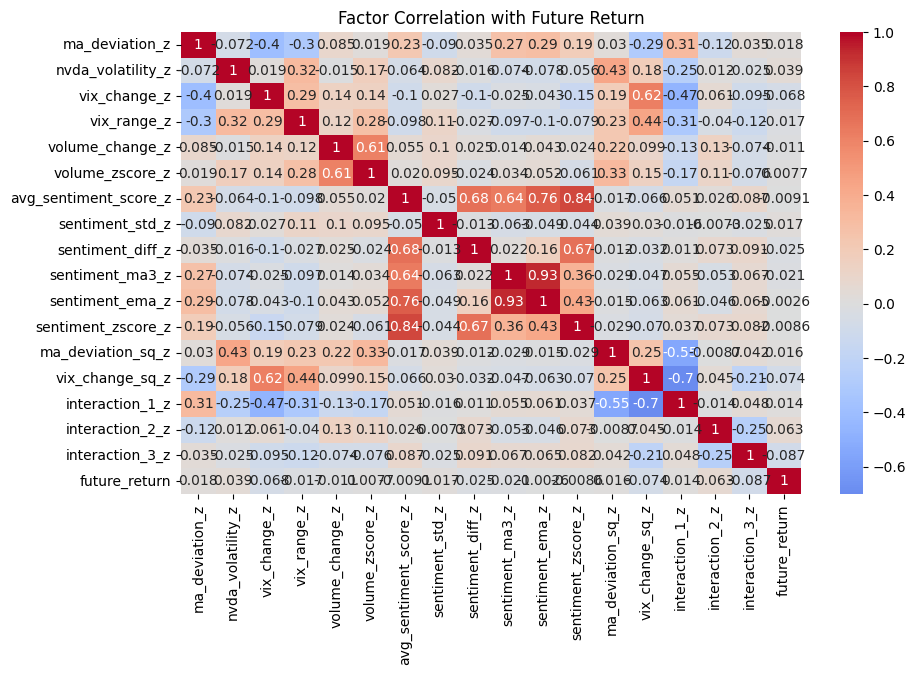

📌 XGBoost Importance Ranking：
                feature  importance
5         volume_zscore    0.097292
13        vix_change_sq    0.077257
15        interaction_2    0.066917
1       nvda_volatility    0.063620
2            vix_change    0.059472
3             vix_range    0.058153
14        interaction_1    0.057340
12      ma_deviation_sq    0.056666
6   avg_sentiment_score    0.055958
16        interaction_3    0.055757
10        sentiment_ema    0.054663
0          ma_deviation    0.052014
7         sentiment_std    0.051620
9         sentiment_ma3    0.051548
4         volume_change    0.048888
11     sentiment_zscore    0.048546
8        sentiment_diff    0.044287


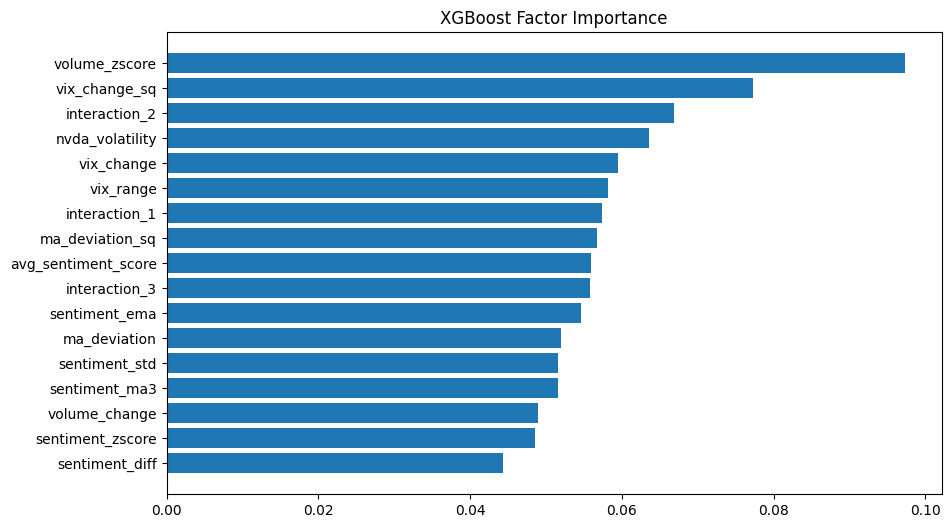

In [15]:
# ========== Visualization: correlation of factors with future returns ==========
cor_matrix = df[[f + '_z' for f in raw_factors] + ['future_return']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Factor Correlation with Future Return")
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

X = df[raw_factors].copy()
y = df['future_return']

# Fill in missing values or delete missing rows
X = X.dropna()
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_scaled, y)

# Acquisition Importance
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("📌 XGBoost Importance Ranking：")
print(importance_df)

# visualization
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Factor Importance")
plt.show()

# chose features with importance > 0.01
xgb_selected = importance_df.query('importance > 0.01')['feature'].tolist()


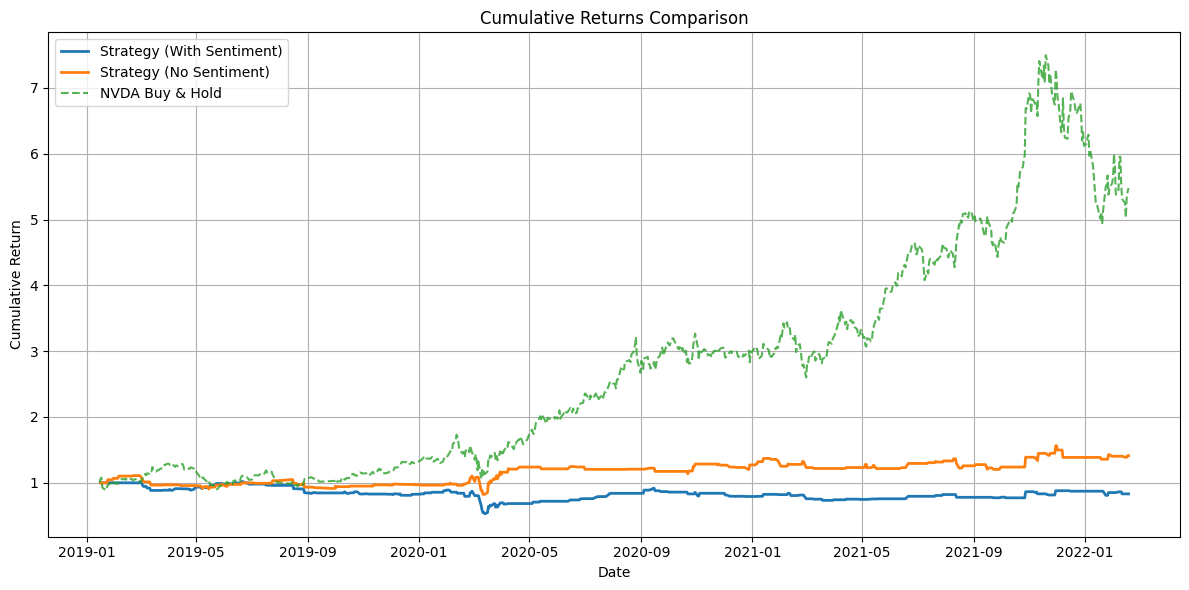

==== Performance Comparison ====
With Sentiment     - Annual Return: -2.36%, Volatility: 27.27%, Sharpe: -0.09
Without Sentiment  - Annual Return: 15.32%, Volatility: 27.66%, Sharpe: 0.55
Benchmark (NVDA)   - Annual Return: 68.61%, Volatility: 49.10%, Sharpe: 1.40


In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# === 1. Original Strategy: Include Emotional Factors ===
selected_all = [
    'nvda_volatility', 'vix_change', 'sentiment_ma3', 'interaction_3',
    'vix_change_sq', 'sentiment_std', 'sentiment_ema', 'ma_deviation',
    'avg_sentiment_score', 'volume_change', 'sentiment_diff'
]

# new strategy: exclude emotional factors
sentiment_features = ['sentiment_ma3', 'interaction_3', 'sentiment_std', 'sentiment_ema',
                      'avg_sentiment_score', 'sentiment_diff']
selected_non_sentiment = [f for f in selected_all if f not in sentiment_features]

# standardize and lagging (to prevent future information leakage)
df_all_shifted = df[selected_all].shift(1)
df_non_sent_shifted = df[selected_non_sentiment].shift(1)

scaler_all = StandardScaler()
scaler_non = StandardScaler()

df_all_scaled = pd.DataFrame(scaler_all.fit_transform(df_all_shifted), columns=selected_all, index=df.index)
df_non_scaled = pd.DataFrame(scaler_non.fit_transform(df_non_sent_shifted), columns=selected_non_sentiment, index=df.index)

# === 2. Construct integrated signals  ===
weights_all = importance_df.set_index('feature').loc[selected_all]['importance'].values
weights_all = weights_all / weights_all.sum()

weights_non = importance_df.set_index('feature').loc[selected_non_sentiment]['importance'].values
weights_non = weights_non / weights_non.sum()

df['composite_signal_all'] = df_all_scaled.mul(weights_all, axis=1).sum(axis=1)
df['composite_signal_non'] = df_non_scaled.mul(weights_non, axis=1).sum(axis=1)

# === 3. Signal to position ===
upper_all = df['composite_signal_all'].quantile(0.90)
lower_all = df['composite_signal_all'].quantile(0.10)

upper_non = df['composite_signal_non'].quantile(0.90)
lower_non = df['composite_signal_non'].quantile(0.10)

df['position_all'] = 0
df.loc[df['composite_signal_all'] > upper_all, 'position_all'] = 1
df.loc[df['composite_signal_all'] < lower_all, 'position_all'] = -1

df['position_non'] = 0
df.loc[df['composite_signal_non'] > upper_non, 'position_non'] = 1
df.loc[df['composite_signal_non'] < lower_non, 'position_non'] = -1


# === 4. Strategy Returns and Cumulative Returns ===
df['return_all'] = df['position_all'].shift(1) * df['future_return']
df['return_non'] = df['position_non'].shift(1) * df['future_return']
df['cumulative_all'] = (1 + df['return_all']).cumprod()
df['cumulative_non'] = (1 + df['return_non']).cumprod()
df['cumulative_nvda'] = (1 + df['future_return']).cumprod()

# === 5.drawing comparison  ===
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_all'], label='Strategy (With Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_non'], label='Strategy (No Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_nvda'], label='NVDA Buy & Hold', linestyle='--', alpha=0.8)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Performance evaluation function ===
def evaluate_performance(returns):
    ann_ret = np.mean(returns) * 252
    ann_vol = np.std(returns) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

# === 7. Output Performance Comparison ===
s1_ret, s1_vol, s1_sharpe = evaluate_performance(df['return_all'].dropna())
s2_ret, s2_vol, s2_sharpe = evaluate_performance(df['return_non'].dropna())
b_ret, b_vol, b_sharpe = evaluate_performance(df['future_return'].dropna())

print("==== Performance Comparison ====")
print(f"With Sentiment     - Annual Return: {s1_ret:.2%}, Volatility: {s1_vol:.2%}, Sharpe: {s1_sharpe:.2f}")
print(f"Without Sentiment  - Annual Return: {s2_ret:.2%}, Volatility: {s2_vol:.2%}, Sharpe: {s2_sharpe:.2f}")
print(f"Benchmark (NVDA)   - Annual Return: {b_ret:.2%}, Volatility: {b_vol:.2%}, Sharpe: {b_sharpe:.2f}")